# Recommendation List Unsmoothed Regression

This notebook analyzes the results of straight regression for the recommendation lists.

## Setup

In [1]:
import sys
from pathlib import Path
from textwrap import dedent

In [2]:
import pandas as pd
import numpy as np
import zarr
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from scipy import stats
from scipy.special import expit, logit, logsumexp
from IPython.display import display, Markdown

In [3]:
import bookgender.datatools as dt
from bookgender.config import rng_seed
from lenskit.util import init_rng
from bookgender.nbutils import *

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\fastparquet\dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [4]:
fig_dir = init_figs('UnsmoothedRegression')

using figure dir figures\UnsmoothedRegression


In [5]:
seed = init_rng(rng_seed(), 'UnsmoothedRegression')
rng = np.random.default_rng(seed)
seed

SeedSequence(
    entropy=261868553827208103807548308384201786360,
    spawn_key=(2157177875,),
)

## Load Data

In [7]:
datasets = list(dt.datasets.keys())
datasets = ['GR-I']
datasets

['GR-I']

Load the profile and list data for context:

In [8]:
profiles = pd.read_pickle('data/profile-data.pkl')
rec_lists = pd.read_pickle('data/rec-data.pkl')
rec_lists.head()

ambiguous  female  male  unknown  Total  Known  PropKnown  \
Set Algorithm user                                                              
AZ  als       529           2       8    19       21     50     27       0.54   
              1723          0      12     9       29     50     21       0.42   
              1810          2       6     9       33     50     15       0.30   
              2781          1       8    17       24     50     25       0.50   
              2863          2       4    25       19     50     29       0.58   

                    PropFemale  dcknown  dcyes    PropDC  
Set Algorithm user                                        
AZ  als       529     0.296296       44     23  0.522727  
              1723    0.571429       39     17  0.435897  
              1810    0.400000       31     16  0.516129  
              2781    0.320000       35     17  0.485714  
              2863    0.137931       37     20  0.540541

In [9]:
rec_lists.groupby('Set')['Total'].count()

Set
AZ      34489
BX-E     9806
BX-I    19981
GR-E     9876
GR-I    19994
Name: Total, dtype: int64

Compute the algorithm names:

In [10]:
algo_names = rec_lists.reset_index().groupby('Set')['Algorithm'].apply(lambda x: sorted(x.unique()))
algo_names

Set
AZ      [als, bpr-imp, item-item, item-item-imp, user-...
BX-E                               [item-item, user-user]
BX-I                    [bpr, item-item, user-user, wrls]
GR-E                               [item-item, user-user]
GR-I                    [bpr, item-item, user-user, wrls]
Name: Algorithm, dtype: object

And compute rec list length / distinctness stats:

In [11]:
recs = pd.read_parquet('data/study-recs.parquet')
recs.rename(columns={'dataset': 'Set', 'algorithm': 'Algorithm'}, inplace=True)
recs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9643759 entries, 0 to 9643758
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Set        object 
 1   Algorithm  object 
 2   item       int64  
 3   score      float64
 4   user       int64  
 5   rank       int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 441.5+ MB


In [12]:
list_stats = recs.groupby(['Set', 'Algorithm'])['item'].agg(['count', 'nunique'])
list_stats['distfrac'] = list_stats['nunique'] / list_stats['count']
list_stats['distpct'] = list_stats['distfrac'] * 100
list_stats.head()

count  nunique  distfrac    distpct
Set Algorithm                                          
AZ  als            500000    72395  0.144790  14.479000
    bpr-imp        500000    19763  0.039526   3.952600
    item-item      455485   180243  0.395717  39.571665
    item-item-imp  499750   198097  0.396392  39.639220
    user-user      337125   169069  0.501502  50.150241

Let's load the samples!

In [13]:
samples = {}
summary = {}
for ds in datasets:
    _zf = zarr.ZipStore(f'data/{ds}/inference/unsmoothed/samples.zarr', mode='r')
    _c = zarr.LRUStoreCache(_zf, 2**30)
    samples[ds] = zarr.group(_c)
    summary[ds] = pd.read_csv(f'data/{ds}/inference/unsmoothed-summary.csv', index_col='name')
summary = pd.concat(summary, names=['Set'])
summary.head()

Mean      MCSE      StdDev             5%  \
Set  name                                                          
GR-I lp__    -382571.000000  2.100160  111.484000 -382755.000000   
     recB[1]      -0.035497  0.000250    0.012958      -0.056753   
     recB[2]       0.128757  0.000257    0.012553       0.108128   
     recB[3]      -0.164321  0.000278    0.012433      -0.185094   
     recB[4]      -0.075397  0.000181    0.010170      -0.092127   

                        50%            95%    N_Eff   N_Eff/s    R_hat  
Set  name                                                               
GR-I lp__    -382570.000000 -382389.000000  2817.89  1.323810  1.00077  
     recB[1]      -0.035572      -0.014487  2694.06  1.265640  1.00118  
     recB[2]       0.128765       0.149325  2390.41  1.122980  1.00143  
     recB[3]      -0.164234      -0.143905  2003.64  0.941285  1.00144  
     recB[4]      -0.075361      -0.058547  3171.68  1.490010  1.00084

In [15]:
sample_size = len(samples['GR-I']['lp__'])
sample_size

10000

## Quality of Fit and Sample

Do we have any parameters with troubling $\hat{R}$ values?

In [16]:
summary.sort_values('R_hat', ascending=False).head()

Mean      MCSE   StdDev       5%      50%      95%  \
Set  name                                                                   
GR-I log_lik[1406] -11.5115  0.023160  1.45058 -14.3531 -11.1668  -9.8289   
     log_lik[1108] -16.6260  0.024758  1.44785 -19.4383 -16.2871 -14.9404   
     log_lik[4676] -13.9019  0.024798  1.41183 -16.6443 -13.5854 -12.2619   
     log_lik[2550] -12.8088  0.025114  1.46222 -15.6725 -12.4524 -11.1188   
     log_lik[1307] -12.4206  0.023090  1.42418 -15.1930 -12.1153 -10.7387   

                      N_Eff  N_Eff/s    R_hat  
Set  name                                      
GR-I log_lik[1406]  3922.75  1.84286  1.00337  
     log_lik[1108]  3419.99  1.60667  1.00323  
     log_lik[4676]  3241.52  1.52283  1.00319  
     log_lik[2550]  3389.82  1.59249  1.00316  
     log_lik[1307]  3804.41  1.78726  1.00301

And let's compute LPPD and WAIC to assess model fit:

In [17]:
def ll_stats(ds):
    ll_exp = samples[ds]['ll_exp']
    ll_var = samples[ds]['ll_var']
    lppd = np.sum(ll_exp)
    pwaic = np.sum(ll_var)
    return pd.Series({'lppd': lppd, 'pWAIC': pwaic, 'WAIC': -2 * (lppd - pwaic)})
pd.Series(datasets).apply(ll_stats).assign(Set=datasets).set_index('Set')

,lppd,pWAIC,WAIC
Set,,,
GR-I,-63316.615404,10147.767048,146928.764902


## Helper Functions

We want some functions for extracting data.  Some of our things are per-list samples:

In [18]:
def list_samples(field, mean=False):
    def _extract():
        for ds, zg in samples.items():
            data = zg[field][...].T
            data = pd.DataFrame(data, index=rec_lists.loc[ds, :].index)
            data.columns.name = 'Sample'
            if mean:
                data = data.mean(axis=1)
            yield ds, data
    
    return pd.concat(dict(_extract()), names=['Set'])

Others are per-algorithm samples:

In [19]:
def algo_samples(field):
    def _extract():
        for ds, zg in samples.items():
            data = zg[field][...].T
            names = algo_names[ds]
            data = pd.DataFrame(data, index=names)
            data.columns.name = 'Sample'
            data.index.name = 'Algorithm'
            yield ds, data
    
    return pd.concat(dict(_extract()), names=['Set'])

Repeat these helper functions for extracting implicit/explicit results:

In [20]:
def select_implicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Set'].str.endswith('-I')
    if 'Algorithm' in data.columns:
        implicit |= data['Algorithm'].str.endswith('-imp')
    else:
        implicit |= data['Set'] == 'AZ'
    data = data.loc[implicit].assign(Set=data['Set'].str.replace('-I', ''))
    if 'Algorithm' in data.columns:
        data['Algorithm'] = data['Algorithm'].str.replace('-imp', '').str.replace('wrls', 'als')
    return data

In [21]:
def select_explicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Set'].str.endswith('-I') 
    if 'Algorithm' in data.columns:
        implicit |= data['Algorithm'].str.endswith('-imp')
    data = data[~implicit].assign(Set=data['Set'].str.replace('-E', ''))
    return data

## Plotting Distributions

Let's plot the distributions of rec list biases.  First we need to extract mean biases from the underlying samples, grouped by algorithm family.  These are in log-odds space, `expit` translates them back:

In [22]:
bias_smooth = algo_samples('biasP').stack()
bias_smooth = expit(bias_smooth)
bias_smooth.head()

KeyError: 'biasP'

Now we need expected new recommendation list proportions.  This starts with the bias, plus the recommender's variance; the MCMC sampler outputs this as `thetaRP`.  We then feed it in to a binomial distribution, with known-item counts sampled from the data, as with user profiles.

In [29]:
bias_pred = algo_samples('thetaRP').stack()
bias_pred.head()

Set  Algorithm  Sample
AZ   als        0         0.516493
                1         0.404317
                2         0.507226
                3         0.244397
                4         0.464367
dtype: float64

In [30]:
def _samp_obs(s):
    known = rec_lists.loc[s.name, 'Known']
    ns = rng.choice(known, len(s), replace=True)
    ys = rng.binomial(ns, s)
    return pd.Series(ys / ns, index=s.index)
bias_pred = bias_pred.groupby('Set').apply(_samp_obs)
bias_pred

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Set   Algorithm  Sample
AZ    als        0         0.461538
                 1         0.200000
                 2         0.586207
                 3         0.142857
                 4         0.560000
                             ...   
GR-I  wrls       9995      0.489362
                 9996      0.351351
                 9997      0.794872
                 9998      0.871795
                 9999      0.076923
Length: 190000, dtype: float64

In [31]:
def resample(x, n=sample_size):
    s = pd.Series(rng.choice(x, n, replace=True))
    s.index.name = 'Sample'
    return s

Now we need the observed biases.  For comparability, these should be the damped biases:

In [32]:
rec_lists['Bias'] = (rec_lists['female'] + 1) / (rec_lists['Known'] + 2)

In [33]:
bias_obs = rec_lists.groupby(['Set', 'Algorithm'])['PropFemale'].apply(resample)
bias_obs.head()

Set  Algorithm  Sample
AZ   als        0         0.533333
                1         0.300000
                2         0.538462
                3         0.545455
                4         0.533333
Name: PropFemale, dtype: float64

In [40]:
bias_data = pd.concat(dict(
    Smoothed=bias_smooth,
    Predicted=bias_pred,
    Observed=bias_obs
), names=['Mode']).reset_index(name='Value')
bias_data['Mode'] = bias_data['Mode'].astype('category')
bias_data['Mode'].cat.reorder_categories(['Smoothed', 'Predicted', 'Observed'], inplace=True)
bias_data.head()

,Mode,Set,Algorithm,Sample,Value
0,Smoothed,AZ,als,0,0.463698
1,Smoothed,AZ,als,1,0.433909
2,Smoothed,AZ,als,2,0.432965
3,Smoothed,AZ,als,3,0.371445
4,Smoothed,AZ,als,4,0.455159


Let's plot the **implicit** runs:

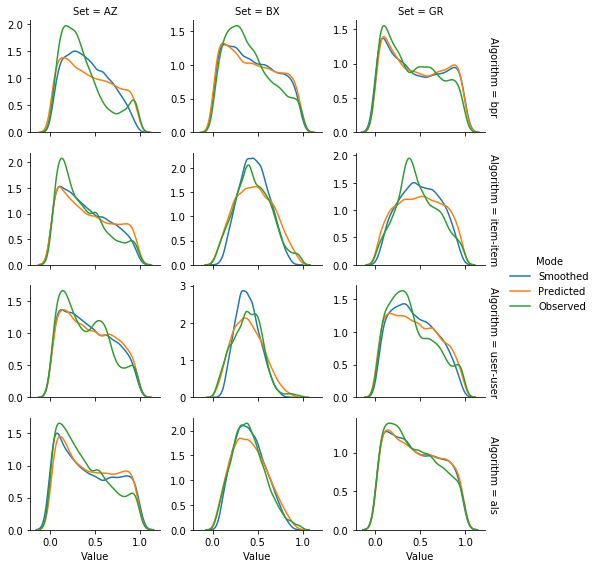

In [25]:
grid = sns.FacetGrid(col='Set', row='Algorithm', hue='Mode',
                     data=select_implicit(bias_data),
                     sharey=False, aspect=1.2, height=2, margin_titles=True)
grid.map(sns.kdeplot, 'Value', clip=(0,1)).add_legend()
#plt.savefig(fig_dir / 'rec-implicit-dense.pdf')

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\rec-implicit-dense.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 442 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 442 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


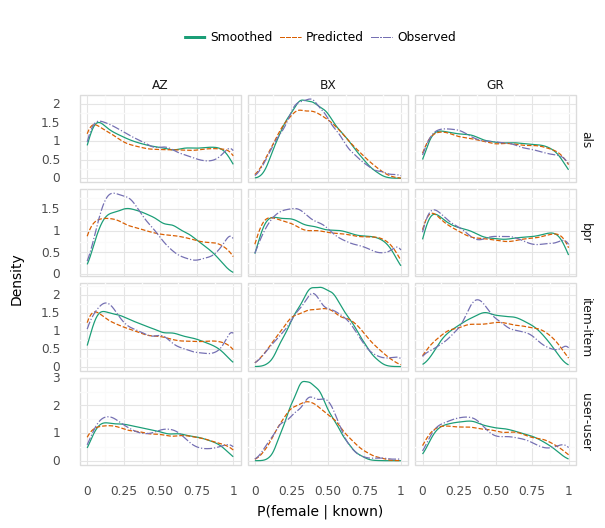

<ggplot: (-9223371879896643416)>

In [42]:
make_plot(select_implicit(bias_data), aes('Value', color='Mode', linetype='Mode'),
          geom_line(stat='density', bw='scott', clip=(0,1)),
          scale_color_brewer('qual', 'Dark2'),
          facet_grid('Algorithm ~ Set', scales='free_y'),
          xlab('P(female | known)'), ylab('Density'),
          legend_position='top', legend_title=element_blank(),
          file='rec-implicit-dense.pdf', width=8, height=8)

And the **explicit** runs:

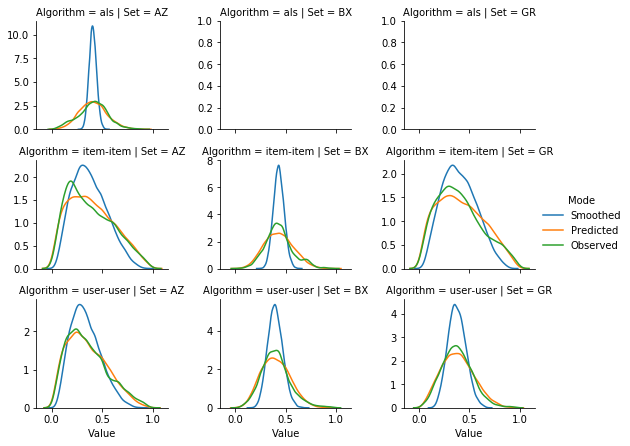

In [27]:
grid = sns.FacetGrid(col='Set', row='Algorithm', hue='Mode',
                     data=select_explicit(bias_data),
                     sharey=False, aspect=1.2, height=2.1)
grid.map(sns.kdeplot, 'Value', clip=(0,1)).add_legend()
# plt.savefig(fig_dir / 'rec-explicit-dense.pdf')

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 6.2 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\rec-explicit-dense.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 495 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 495 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


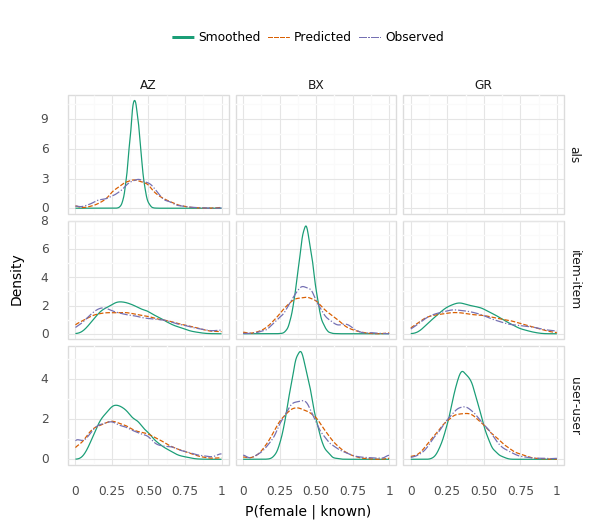

<ggplot: (-9223371879914065224)>

In [43]:
make_plot(select_explicit(bias_data), aes('Value', color='Mode', linetype='Mode'),
          geom_line(stat='density', bw='scott', clip=(0,1)),
          scale_color_brewer('qual', 'Dark2'),
          facet_grid('Algorithm ~ Set', scales='free_y'),
          xlab('P(female | known)'), ylab('Density'),
          legend_position='top', legend_title=element_blank(),
          file='rec-explicit-dense.pdf', width=8, height=6.2)

## Examining Regression Parameters

In [44]:
params = pd.DataFrame({
    'Intercept': algo_samples('recB').mean(axis=1),
    'Slope': algo_samples('recS').mean(axis=1),
    'Variance': algo_samples('recV').mean(axis=1)
})
params.head()

Intercept     Slope  Variance
Set Algorithm                                   
AZ  als            -0.340200  0.083769  0.327833
    bpr-imp        -0.145875  0.670236  1.014495
    item-item      -0.387055  0.443715  0.750027
    item-item-imp  -0.233989  0.816844  1.017883
    user-user      -0.582308  0.393841  0.543090

In [45]:
param_samples = pd.DataFrame({
    'Intercept': algo_samples('recB').stack(),
    'Slope': algo_samples('recS').stack(),
    'Variance': algo_samples('recV').stack()
})
param_samples.head()

Intercept     Slope  Variance
Set Algorithm Sample                               
AZ  als       0       -0.340287  0.088264  0.346577
              1       -0.346170  0.083845  0.349899
              2       -0.344464  0.086761  0.344848
              3       -0.346058  0.081484  0.347823
              4       -0.343580  0.081330  0.334686

In [46]:
def reg_ints(df):
    return pd.Series({
        'I_mean': df.Intercept.mean(),
        'I_lo': df.Intercept.quantile(0.025),
        'I_hi': df.Intercept.quantile(0.975),
        'S_mean': df.Slope.mean(),
        'S_lo': df.Slope.quantile(0.025),
        'S_hi': df.Slope.quantile(0.975)
    })

### Implicit Parameters

What are the **implicit** parameters?

In [47]:
select_implicit(params).pivot(index='Algorithm', columns='Set', values=['Intercept', 'Slope', 'Variance'])

Intercept                         Slope                      \
Set              AZ        BX        GR        AZ        BX        GR   
Algorithm                                                               
als       -0.027340 -0.108892 -0.049199  1.033907  0.740596  1.123047   
bpr       -0.145875  0.244467 -0.006709  0.670236  1.397031  1.353020   
item-item -0.233989  0.100269  0.144350  0.816844  0.663304  0.782653   
user-user -0.074351 -0.261027 -0.146885  0.807383  0.544951  0.900420   

           Variance                      
Set              AZ        BX        GR  
Algorithm                                
als        0.591241  0.248210  0.403451  
bpr        1.014495  0.490391  0.657638  
item-item  1.017883  0.629724  0.682272  
user-user  0.507979  0.414213  0.652115

In [48]:
imp_recB = select_implicit(algo_samples('recB')).set_index(['Set', 'Algorithm'])
imp_recS = select_implicit(algo_samples('recS')).set_index(['Set', 'Algorithm'])
imp_recV = select_implicit(algo_samples('recV')).set_index(['Set', 'Algorithm'])
imp_ds = imp_recB.index.levels[0]
imp_as = imp_recB.index.levels[1]

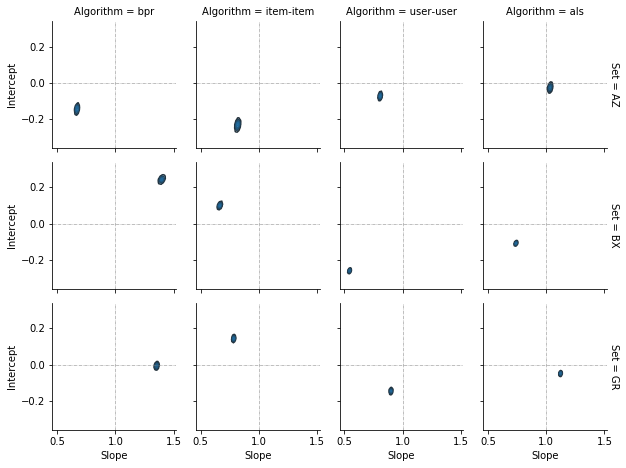

In [49]:
grid = sns.FacetGrid(col='Algorithm', row='Set', data=select_implicit(param_samples), margin_titles=True, height=2.2)
def _si_kde(*args, **kwargs):
    plt.axhline(0, 0, 1, ls='-.', lw=0.5, color='grey')
    plt.axvline(1, 0, 1, ls='-.', lw=0.5, color='grey')
    sns.kdeplot(*args, levels=5, **kwargs)
grid.map(_si_kde, 'Slope', 'Intercept')
plt.savefig(fig_dir / 'reg-param-implicit.pdf')

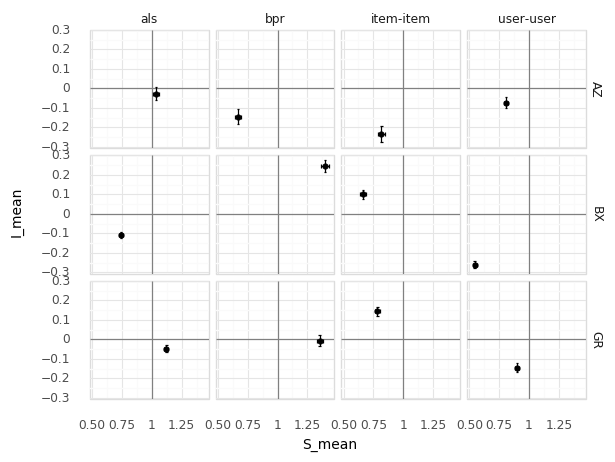

<ggplot: (-9223371879916476404)>

In [50]:
imp_cis = select_implicit(param_samples).groupby(['Set', 'Algorithm']).apply(reg_ints)
make_plot(imp_cis.reset_index(),
          aes(x='S_mean', xmin='S_lo', xmax='S_hi',
              y='I_mean', ymin='I_lo', ymax='I_hi'),
          geom_hline(yintercept=0, color='grey'),
          geom_vline(xintercept=1, color='grey'),
          geom_point(),
          geom_errorbar(width=0.02),
          geom_errorbarh(height=0.02),
          facet_grid('Set ~ Algorithm'))

### Explicit Parameters

What are the **explicit** parameters?

In [51]:
select_explicit(params).pivot(index='Algorithm', columns='Set', values=['Intercept', 'Slope', 'Variance'])

Intercept                         Slope                      \
Set              AZ        BX        GR        AZ        BX        GR   
Algorithm                                                               
als       -0.340200       NaN       NaN  0.083769       NaN       NaN   
item-item -0.387055 -0.212644 -0.317620  0.443715  0.179800  0.516584   
user-user -0.582308 -0.328488 -0.453477  0.393841  0.261503  0.251879   

           Variance                      
Set              AZ        BX        GR  
Algorithm                                
als        0.327833       NaN       NaN  
item-item  0.750027  0.440680  0.756422  
user-user  0.543090  0.400407  0.447869

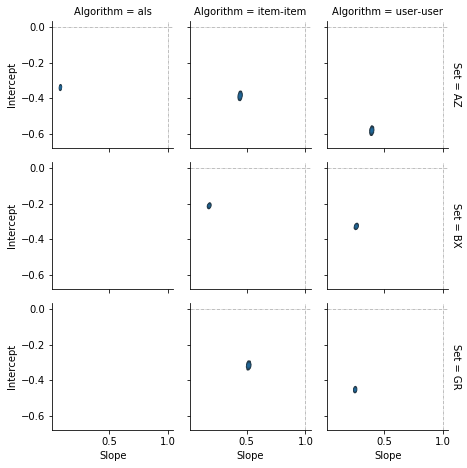

In [52]:
grid = sns.FacetGrid(col='Algorithm', row='Set', data=select_explicit(param_samples), margin_titles=True, height=2.2)
def _si_kde(*args, **kwargs):
    plt.axhline(0, 0, 1, ls='-.', lw=0.5, color='grey')
    plt.axvline(1, 0, 1, ls='-.', lw=0.5, color='grey')
    sns.kdeplot(*args, levels=5, **kwargs)
grid.map(_si_kde, 'Slope', 'Intercept')
plt.savefig(fig_dir / 'reg-param-explicit.pdf')

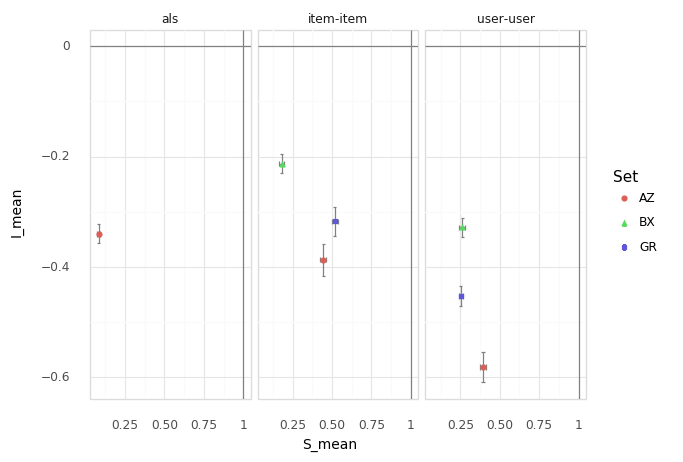

<ggplot: (-9223371879913635848)>

In [53]:
exp_cis = select_explicit(param_samples).groupby(['Set', 'Algorithm']).apply(reg_ints)
make_plot(exp_cis.reset_index(),
          aes(x='S_mean', xmin='S_lo', xmax='S_hi',
              y='I_mean', ymin='I_lo', ymax='I_hi'),
          geom_hline(yintercept=0, color='grey'),
          geom_vline(xintercept=1, color='grey'),
          geom_errorbar(width=0.02, color='grey'),
          geom_errorbarh(height=0.01, color='grey'),
          geom_point(aes(color='Set', shape='Set')),
          facet_grid('~ Algorithm'))

### Integrated Plots

Let's try to put these parameter plots into a single display.

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\reg-params-all.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


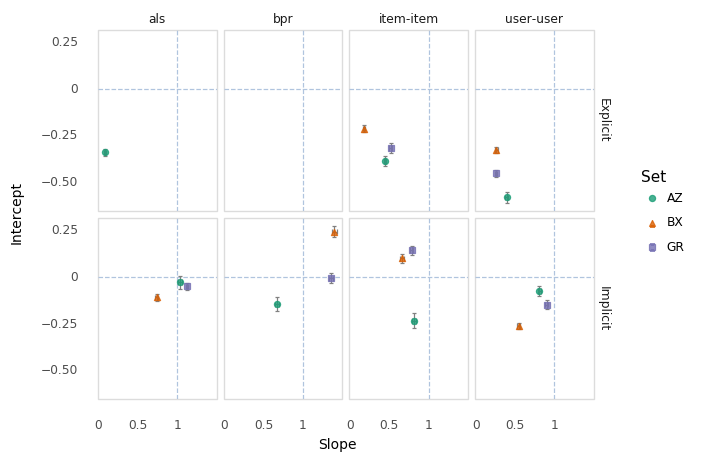

<ggplot: (-9223371879896809292)>

In [54]:
param_conf = pd.concat({
    'Explicit': exp_cis,
    'Implicit': imp_cis
}, names=['Mode'])
make_plot(param_conf.reset_index(),
          aes(x='S_mean', xmin='S_lo', xmax='S_hi',
              y='I_mean', ymin='I_lo', ymax='I_hi'),
          geom_hline(yintercept=0, color='lightsteelblue', linetype='dashed'),
          geom_vline(xintercept=1, color='lightsteelblue', linetype='dashed'),
          geom_errorbar(width=0.05, color='grey'),
          geom_errorbarh(height=0.03, color='grey'),
          geom_point(aes(color='Set', shape='Set'), size=2, alpha=0.8),
          facet_grid('Mode ~ Algorithm'),
          scale_color_brewer('qual', 'Dark2'),
          xlab('Slope'), ylab('Intercept'),
          file='reg-params-all.pdf', width=8, height=5,
          panel_grid=element_blank())

## Plotting Regressions

Let's plot those regressions.

### Implicit Feedback

We will start with **implicit** data:

In [55]:
imp_points = pd.merge(
    select_implicit(profiles)[['Set', 'user', 'PropFemale']],
    select_implicit(rec_lists)[['Set', 'Algorithm', 'user', 'Bias']]
).set_index(['Set', 'Algorithm', 'user'])
imp_points.head()

PropFemale      Bias
Set Algorithm user                      
AZ  bpr       529     0.800000  0.466667
    item-item 529     0.800000  0.777778
    user-user 529     0.800000  0.685714
    als       529     0.800000  0.785714
    bpr       1723    0.285714  0.270833

In [56]:
imp_params = select_implicit(params).set_index(['Set', 'Algorithm'])
xs = np.linspace(0, 1, 201)
imp_curves = np.outer(imp_params['Slope'], logit(xs))
imp_curves = imp_curves + imp_params['Intercept'].values.reshape((len(imp_params), 1))
imp_curves = expit(imp_curves)
imp_curves = pd.DataFrame(imp_curves, index=imp_params.index, columns=xs)
imp_curves.columns.name = 'x'
imp_curves = imp_curves.stack().reset_index(name='y')
imp_curves

,Set,Algorithm,x,y
0,AZ,bpr,0.000,0.000000
1,AZ,bpr,0.005,0.024277
2,AZ,bpr,0.010,0.038210
3,AZ,bpr,0.015,0.049711
4,AZ,bpr,0.020,0.059844
...,...,...,...,...
2407,GR,als,0.980,0.986894
2408,GR,als,0.985,0.990532
2409,GR,als,0.990,0.994008
2410,GR,als,0.995,0.997256


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\rec-scatter-imp.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


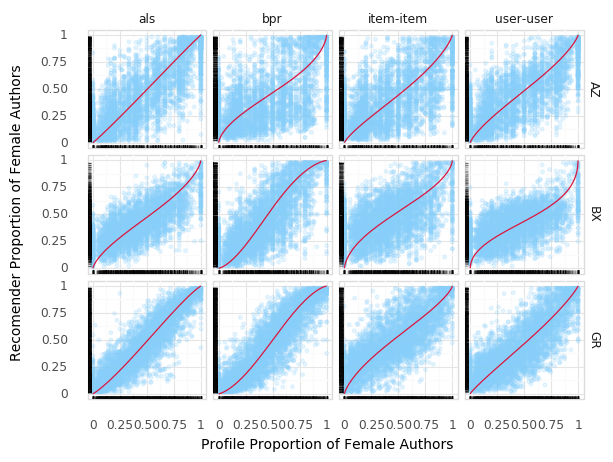

<ggplot: (-9223371879913064492)>

In [57]:
make_plot(imp_points.reset_index(),
          aes('PropFemale', 'Bias'),
          geom_point(alpha=0.2, color='lightskyblue', size=1),
          geom_rug(alpha=0.1),
          geom_line(aes('x', 'y'), imp_curves, color='crimson'),
          facet_grid('Set ~ Algorithm'),
          xlab('Profile Proportion of Female Authors'),
          ylab('Recomender Proportion of Female Authors'),
          file='rec-scatter-imp.pdf', width=8, height=7)

### Explicit Feedback

And the **explicit** data:

In [58]:
exp_points = pd.merge(
    select_explicit(profiles)[['Set', 'user', 'PropFemale']],
    select_explicit(rec_lists)[['Set', 'Algorithm', 'user', 'Bias']]
).set_index(['Set', 'Algorithm', 'user'])
exp_points.head()

PropFemale      Bias
Set Algorithm user                      
AZ  als       529     0.800000  0.310345
    item-item 529     0.800000  0.666667
    user-user 529     0.800000  0.551724
    als       1723    0.285714  0.565217
    item-item 1723    0.285714  0.500000

In [59]:
exp_params = select_explicit(params).set_index(['Set', 'Algorithm'])
xs = np.linspace(0, 1, 201)
exp_curves = np.outer(exp_params['Slope'], logit(xs))
exp_curves = exp_curves + exp_params['Intercept'].values.reshape((len(exp_params), 1))
exp_curves = expit(exp_curves)
exp_curves = pd.DataFrame(exp_curves, index=exp_params.index, columns=xs)
exp_curves.columns.name = 'x'
exp_curves = exp_curves.stack().reset_index(name='y')
exp_curves

,Set,Algorithm,x,y
0,AZ,als,0.000,0.000000
1,AZ,als,0.005,0.313541
2,AZ,als,0.010,0.326265
3,AZ,als,0.015,0.333869
4,AZ,als,0.020,0.339345
...,...,...,...,...
1402,GR,user-user,0.980,0.628734
1403,GR,user-user,0.985,0.645778
1404,GR,user-user,0.990,0.669060
1405,GR,user-user,0.995,0.706780


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 5.5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\rec-scatter-exp.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


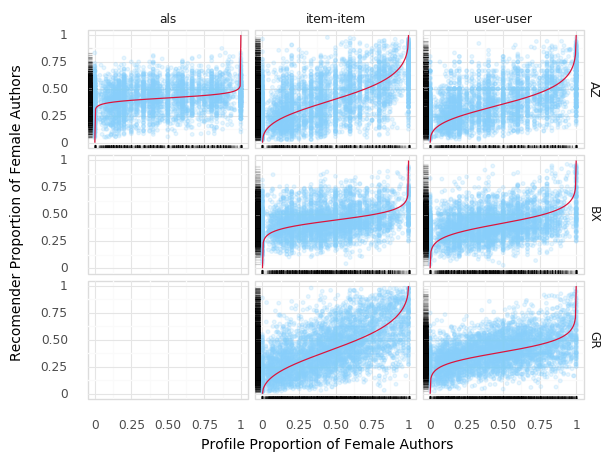

<ggplot: (-9223371879882146740)>

In [60]:
make_plot(exp_points.reset_index(),
          aes('PropFemale', 'Bias'),
          geom_point(alpha=0.2, color='lightskyblue', size=1),
          geom_rug(alpha=0.1),
          geom_line(aes('x', 'y'), exp_curves, color='crimson'),
          facet_grid('Set ~ Algorithm'),
          xlab('Profile Proportion of Female Authors'),
          ylab('Recomender Proportion of Female Authors'),
          file='rec-scatter-exp.pdf', width=8, height=5.5)